# 2. Tensorflow Prophet Testing

## I - Setup

In [5]:
# Import of librairies
import tensorflow as tf
import mysql.connector as mariadb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tqdm import tqdm
from joblib import load
from timeloop import Timeloop
from datetime import timedelta
import time 

class sql_query:
    def __init__(self, credentials_path):
        self.db_credentials = pd.read_csv(credentials_path, index_col="Field")
      
    
    def __call__(self, query):
        
        mariadb_connection = mariadb.connect(
            user=self.db_credentials.loc["user"][0],
            password=self.db_credentials.loc["password"][0],
            host=self.db_credentials.loc["host"][0],
            port=3306,
            db = "db_velib")
        
        self.cursor = mariadb_connection.cursor()
        cursor = self.cursor
        cursor.execute("SET  time_zone = 'Europe/Paris'")
        cursor.execute(query)
        field_names = [i[0] for i in cursor.description]
        df = pd.DataFrame(cursor, columns=field_names)
        return df
    
# Transforming the input data in the proper format 


def measure_rmse(actual, predicted):
    return math.sqrt(mean_squared_error(actual, predicted))

def list_stations():
    request = sql_query("../../aws_mariadb_crendentials - write.csv")
    query = """
    SELECT DISTINCT station_id FROM velib_realtime
    """
    df= request(query)
    # Removing bad values
    df= df.drop(0)
    df = df.drop(1391)
    list_of_stations = list(df.station_id)
    return list_of_stations

def loading_models(list_of_stations):
    LSTM_A_list = []
    LSTM_B_list = []
    std_list = []

    for i in list_of_stations:
        LSTM_A_list.append("LSTM A - {} - {}".format(i, day_of_testing))
        LSTM_B_list.append("LSTM B - {} - {}".format(i, day_of_testing))
        std_list.append("std - {} - {}".format(i, day_of_testing))

    for i in tqdm(range(len(list_of_stations))):
        try:
            LSTM_A_list[i] = tf.keras.models.load_model('/home/exalis/Github/velib-prediction-v2/4. Models/Tensorflow Univariate - {} - {} - LSTM_A.h5'.format(day_of_testing, list_of_stations[i]))
            LSTM_B_list[i] = tf.keras.models.load_model('/home/exalis/Github/velib-prediction-v2/4. Models/Tensorflow Univariate - {} - {} - LSTM_B.h5'.format(day_of_testing, list_of_stations[i]))
            std_list[i] = load('/home/exalis/Github/velib-prediction-v2/4. Models/Tensorflow Univariate - {} - {} - std.joblib'.format(day_of_testing, list_of_stations[i]))
        except:
            print('impossible to load ', list_of_stations[i])

    return LSTM_A_list, LSTM_B_list, std_list


def create_result_df():
    # Extracting base for prediction 

    request = sql_query("../../aws_mariadb_crendentials - write.csv")

    query = """
    SELECT station_id, date_of_update, nb_total_free_bikes FROM db_velib.velib_realtime
    WHERE date_of_update >= DATE_SUB(NOW(), INTERVAL 185 Minute) AND MINUTE(date_of_update)%5 = 0
    ORDER BY station_id, date_of_update ASC;
    """
    df= request(query)
    df.index = df.date_of_update
    df = df[['station_id','nb_total_free_bikes']]
    df = df.pivot_table(df, index= 'station_id', columns=df.index)

    # Creating dataframe for proper predction

    df_prediction = pd.DataFrame(index=df.index, columns=['last_observations','model_A', 'model_B', 'date_of_prediction'])
    
    for i in df_prediction.index:
        df_prediction["last_observations"].loc[i] = np.array(df.loc[i])
    
    df_prediction['date_of_prediction'] = str(pd.Timestamp.now())[:16]
    return df_prediction

def predict_iteration():
    # Request for each minutes
    df_prediction = create_result_df()

    for station_index in tqdm(range(len(list_of_stations))):
        # Std Scaling
        try:
            input_data = std_list[station_index].transform(df_prediction[df_prediction.index == list_of_stations[station_index]]["last_observations"].iloc[0].reshape(-1, 1))[-36:]
            df_prediction.loc[list_of_stations[station_index]]['model_A'] = std_list[station_index].inverse_transform(LSTM_A_list[station_index].predict(input_data.reshape(1,past_history,1))[0])
            df_prediction.loc[list_of_stations[station_index]]['model_B'] = std_list[station_index].inverse_transform(LSTM_B_list[station_index].predict(input_data.reshape(1,past_history,1))[0])

        except:
            print('error on ', list_of_stations[station_index])
            
    return df_prediction

## I - Initialization

In [6]:
# Main pipelinhe

# Variables
day_of_testing = '2020-05-17'
past_history = 36
future_target = 6
list_of_stations = list_stations()[:50]
LSTM_A_list, LSTM_B_list, std_list = loading_models(list_of_stations)

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:00<00:05,  8.36it/s]

  4%|▍         | 2/50 [00:00<00:05,  8.65it/s]

  6%|▌         | 3/50 [00:00<00:05,  8.84it/s]

  8%|▊         | 4/50 [00:00<00:05,  9.09it/s]

 10%|█         | 5/50 [00:00<00:04,  9.18it/s]

 12%|█▏        | 6/50 [00:00<00:04,  9.33it/s]

 14%|█▍        | 7/50 [00:00<00:04,  9.35it/s]

 16%|█▌        | 8/50 [00:00<00:04,  9.44it/s]

 18%|█▊        | 9/50 [00:00<00:04,  9.20it/s]

 20%|██        | 10/50 [00:01<00:04,  9.18it/s]

 22%|██▏       | 11/50 [00:01<00:04,  9.18it/s]

 24%|██▍       | 12/50 [00:01<00:04,  9.28it/s]

 26%|██▌       | 13/50 [00:01<00:03,  9.31it/s]

 28%|██▊       | 14/50 [00:01<00:03,  9.37it/s]

 30%|███       | 15/50 [00:01<00:03,  9.39it/s]

 32%|███▏      | 16/50 [00:01<00:03,  9.43it/s]

 34%|███▍      | 17/50 [00:01<00:03,  9.46it/s]

 36%|███▌      | 18/50 [00:01<00:03,  9.43it/s]

 38%|███▊      | 19/50 [00:02<00:03,  9.51it/s]

 40%|████      | 20/50 [00:02<00:03,  9.47it/s]

 42%|████▏     | 21/50 [00:02<00:03,  9.53it/s]

 44%|████▍     | 22/50 [00:02<00:02,  9.46it/s]

 46%|████▌     | 23/50 [00:02<00:02,  9.53it/s]

impossible to load  1119


 50%|█████     | 25/50 [00:02<00:02, 10.54it/s]

 54%|█████▍    | 27/50 [00:02<00:02, 10.22it/s]

 58%|█████▊    | 29/50 [00:03<00:02, 10.02it/s]

 62%|██████▏   | 31/50 [00:03<00:01,  9.88it/s]

 66%|██████▌   | 33/50 [00:03<00:01,  9.70it/s]

 68%|██████▊   | 34/50 [00:03<00:01,  9.63it/s]

 70%|███████   | 35/50 [00:03<00:01,  9.65it/s]

 72%|███████▏  | 36/50 [00:03<00:01,  9.60it/s]

 74%|███████▍  | 37/50 [00:03<00:01,  9.60it/s]

 76%|███████▌  | 38/50 [00:03<00:01,  9.53it/s]

 78%|███████▊  | 39/50 [00:04<00:01,  9.33it/s]

 80%|████████  | 40/50 [00:04<00:01,  9.38it/s]

 82%|████████▏ | 41/50 [00:04<00:00,  9.17it/s]

 84%|████████▍ | 42/50 [00:04<00:00,  9.25it/s]

 86%|████████▌ | 43/50 [00:04<00:00,  9.16it/s]

 88%|████████▊ | 44/50 [00:04<00:00,  9.27it/s]

 90%|█████████ | 45/50 [00:04<00:00,  9.29it/s]

 92%|█████████▏| 46/50 [00:04<00:00,  9.42it/s]

 94%|█████████▍| 47/50 [00:04<00:00,  9.37it/s]

 96%|█████████▌| 48/50 [00:05<00:00,  9.31it/s]

 98%|█████████▊| 49/50 [00:05<00:00,  9.34it/s]

100%|██████████| 50/50 [00:05<00:00,  9.51it/s]


# Main pipelinhe

# Variables
day_of_testing = '2020-05-17'
past_history = 36
future_target = 6
list_of_stations = list_stations()
LSTM_A_list, LSTM_B_list, std_list = loading_models(list_of_stations)

In [16]:
df_prediction = predict_iteration()
df_prediction.to_csv('prediction - {}.csv'.format(str(pd.Timestamp.now())[:16]))

100%|██████████| 50/50 [00:03<00:00, 15.49it/s]



tl = Timeloop()


@tl.job(interval=timedelta(seconds=30))
def predicting_by_5_minutes():
    df_prediction = predict_iteration()
    df_prediction.to_csv('prediction - {}.csv'.format(str(pd.Timestamp.now())[:16]))

In [63]:
df_results.head()

,station_id,last_observations,model_A,model_B,date_of_prediction
0,1001,[15 15 15 15 13 13 14 15 16 16 16 16 15 15 15 ...,[15.312915 15.590853 15.333482 15.449925 15.27...,[15.838733 15.456253 15.489479 15.3114605 1...,2020-05-18 16:21
1,1002,[18 18 17 18 17 17 17 17 18 19 18 17 18 19 18 ...,[18.826777 19.139194 18.404476 18.58532 18.65...,[19.200556 19.026974 19.125639 18.943012 19.24...,2020-05-18 16:21
2,1003,[11 12 12 12 13 13 13 13 14 13 11 13 11 12 12 ...,[18.51714 18.657377 18.86956 19.180878 19.10...,[18.447052 18.41771 18.299164 18.670986 19.00...,2020-05-18 16:21
3,1006,[22 23 23 23 24 25 25 25 25 25 25 25 25 25 25 ...,[28.309422 28.991337 28.875832 28.437538 28.36...,[26.985334 27.161911 26.79192 26.700777 26.63...,2020-05-18 16:21
4,1007,[16 16 16 16 16 16 16 16 6 3 4 3 3 4 4 ...,[13.110538 12.936056 12.930615 12.945024 12.74...,[12.271293 11.9122305 11.710942 11.797232 1...,2020-05-18 16:21


tl.start(block=True)

# Annexe - Graphic analysis test

In [185]:
request = sql_query("../../aws_mariadb_crendentials.csv")

query = """
SELECT * FROM velib_results
"""
df = request(query)

# Limiting data
df = df[:20]

# Modifications

df.last_observations = df.last_observations.apply(lambda x: list(map(float, x[1:-1].split())))
df.model_A = df.model_A.apply(lambda x: list(map(float, x[1:-1].split())))
df.model_B = df.model_B.apply(lambda x: list(map(float, x[1:-1].split())))

df.head()

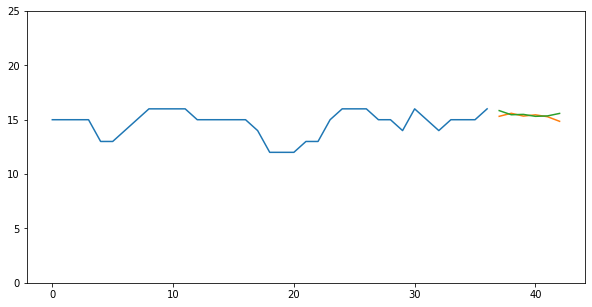

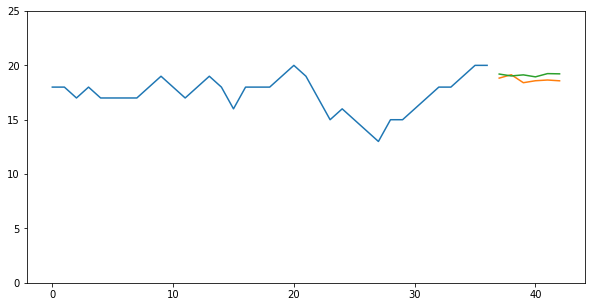

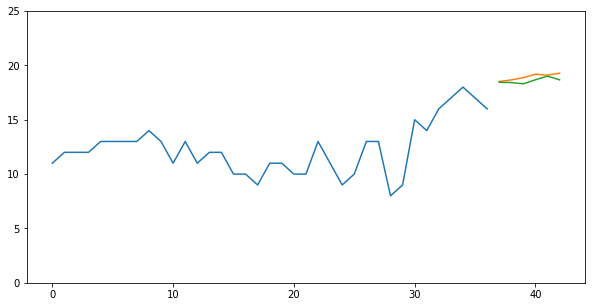

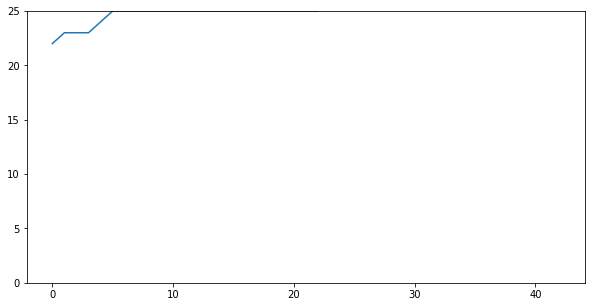

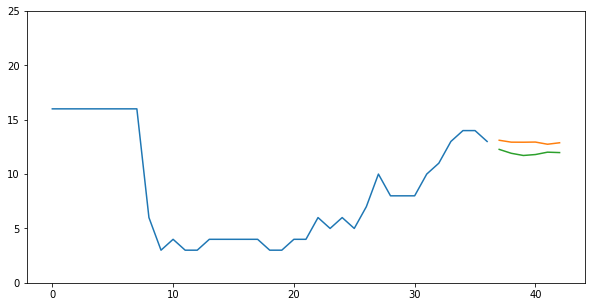

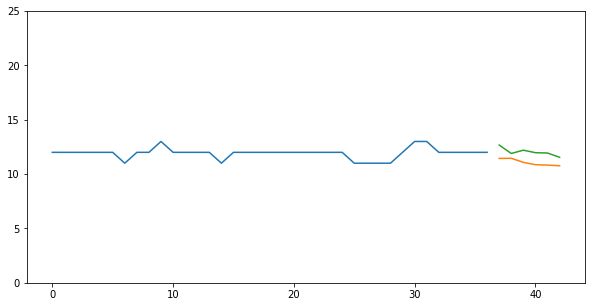

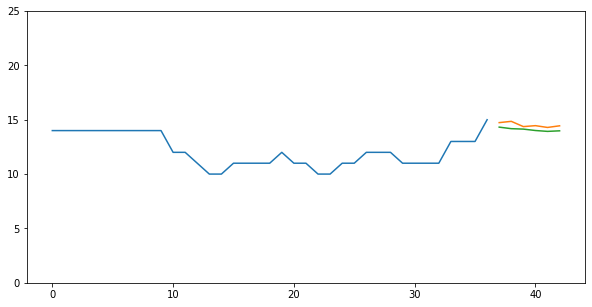

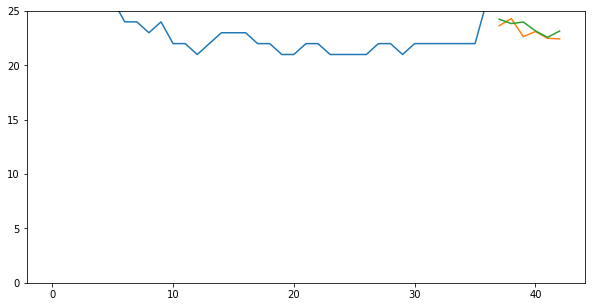

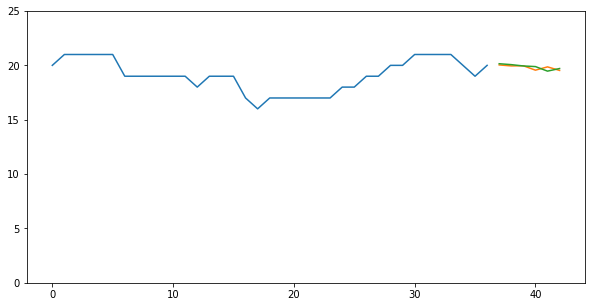

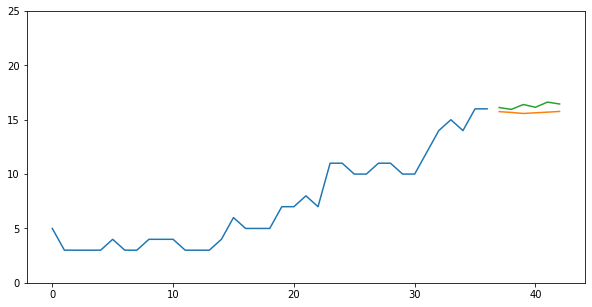

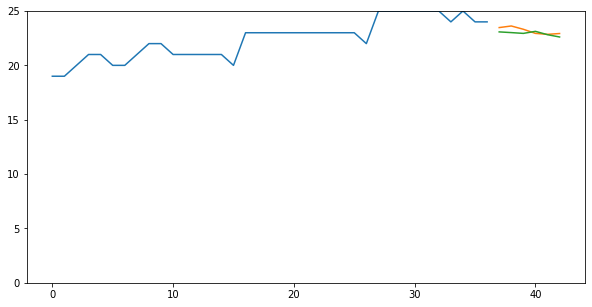

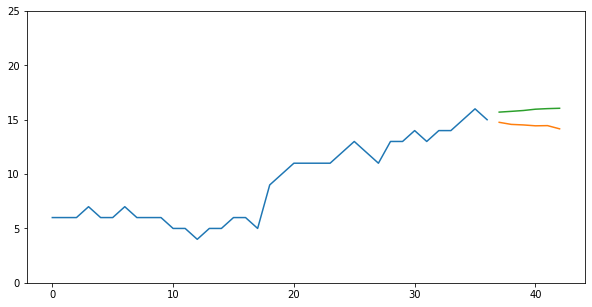

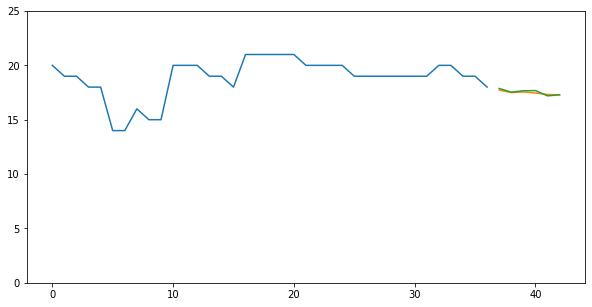

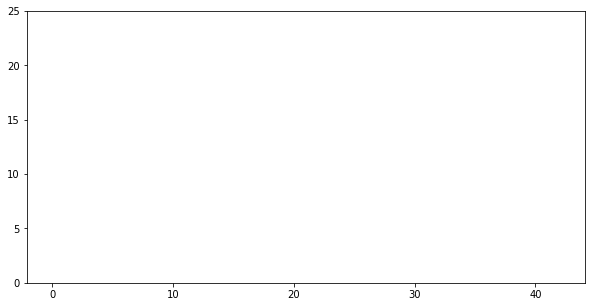

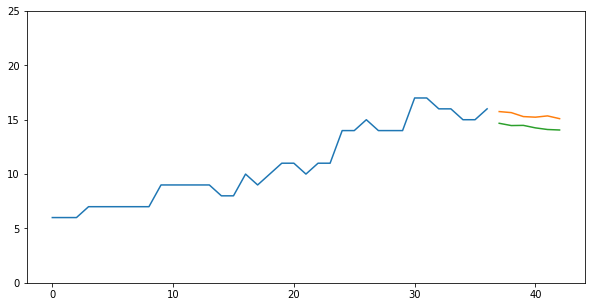

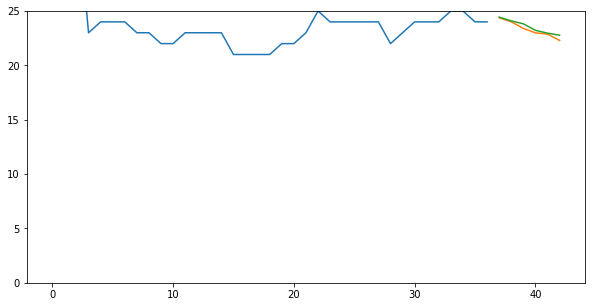

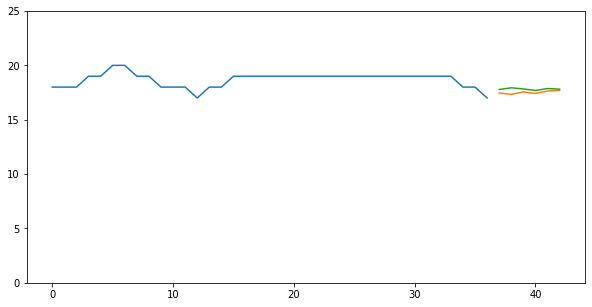

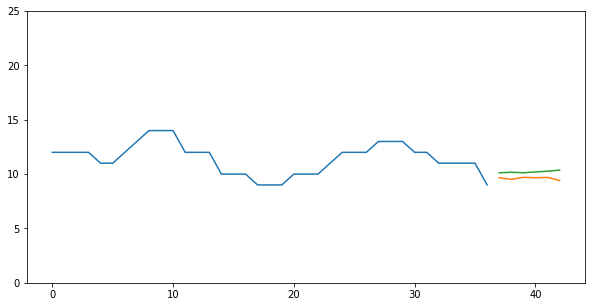

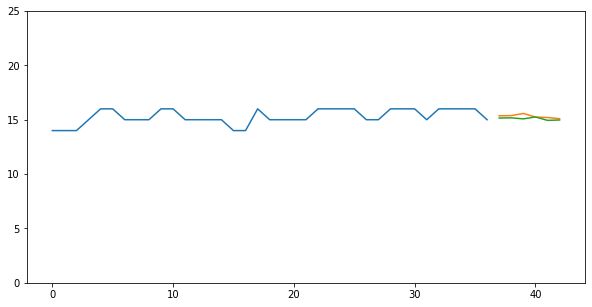

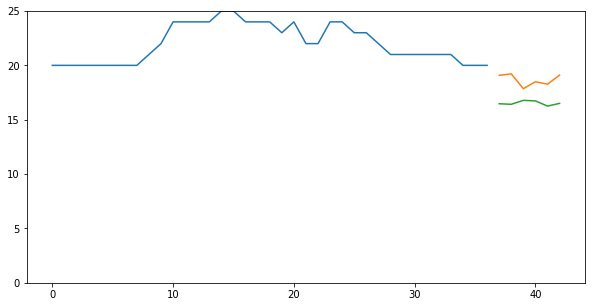

In [212]:
for i in range(20):
    f,ax = plt.subplots(figsize=(10,5))
    ax.set_ylim([0,25])

    sns.lineplot(range(len(df.last_observations[i])), df.last_observations[i])
    sns.lineplot(range(37, 37+len(df.model_A[i])), df.model_A[i])
    sns.lineplot(range(37, 37+len(df.model_B[i])), df.model_B[i])
    plt.show()